# Experimenty
**sobota 16.5.2020 23:59**
- odovzdat spravu + zdrojaky (jupyter) + data + podiel prace v jedn. fazach (zvlast dokument)


- vsetko z minula
- opis DM metod, dovod vyberu
- porovnat metody
- hyperparameter tuning
- metriky (acc-spravnost, prec-presnost, rec-uplnost,f1)


- metodologia - rozdelenie datasetu
- krizova validacia


- zhodnotenie co sa podarilo, porovnanie s ostatnymi (RelWork), dalsie smerovanie projektu
- literatura

In [171]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

## Nacitanie opravenych dat

In [172]:
df_train = pd.read_csv('data/cars_train.csv').drop('Unnamed: 0', axis=1)
df_train.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Manufacturer,Price_km
0,Volkswagen Polo Diesel Trendline 1.2L,Jaipur,2011,77000,Diesel,Manual,First,1199.0,73.9,5.0,2.90,Volkswagen,1375.6231
1,Hyundai i10 Sportz,Hyderabad,2016,19947,Petrol,Manual,First,1197.0,78.9,5.0,4.50,Hyundai,1417.6668
2,Mahindra XUV500 W8 2WD,Kochi,2014,70963,Diesel,Manual,First,2179.0,140.0,7.0,7.83,Mahindra,941.1830


In [173]:
df_test = pd.read_csv('data/cars_test.csv').drop('Unnamed: 0', axis=1)
df_test.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Manufacturer,Price_km
0,Maruti Swift Dzire VDI,Hyderabad,2013,69000,Diesel,Manual,First,1248.0,74.0,5.0,5.75,Maruti,1458.522
1,Mahindra Scorpio 1.99 S4 Plus,Kochi,2017,26741,Diesel,Manual,First,1997.0,120.0,7.0,10.08,Mahindra,959.882
2,Mahindra XUV500 W8 2WD,Delhi,2014,86000,Diesel,Manual,First,2179.0,140.0,7.0,7.85,Mahindra,941.183


## Experimenty

### Rozdelenie datasetu
- df_train: 70%
- df_test: 30% - upravime na test: 15%, valid: 15%

In [181]:
def data_split(x_features, df_train, df_test):
    df_train = df_train.dropna()
    df_test = df_test.dropna()

    valid_limit = int(len(df_test)*0.5)


    x_train = df_train[x_features]
    x_test = df_test[x_features][:valid_limit]
    x_valid = df_test[x_features][valid_limit:]

    y_train = df_train['Price']
    y_test = df_test['Price'][:valid_limit]
    y_valid = df_test['Price'][valid_limit:]

    print(f"Data rozdelene: train = {len(x_train)}, test = {len(x_test)}, valid = {len(x_valid)}")
    return x_train, x_test, x_valid, y_train, y_test, y_valid

# scaler = MinMaxScaler() 
# x_train = scaler.fit_transform(df_train[x_features])
# x_test = scaler.transform(df_test[x_features])
# y_train = scaler.fit_transform(df_train['Price'])
# y_test = scaler.transform(df_test['Price'])

In [192]:
x_features = ['Year','Kilometers_Driven', 'Transmission', 'Owner_Type', 'Price_km',
              'Power', 'Seats', 'Engine']
x_train, x_test, x_valid, y_train, y_test, y_valid = data_split(x_features, df_train, df_test)

Data rozdelene: train = 4140, test = 882, valid = 882


### One-hot encoding and scaling

In [185]:
def encoding(x_train, x_test, x_valid):
    x_train = pd.get_dummies(x_train)
    x_test = pd.get_dummies(x_test)
    x_valid = pd.get_dummies(x_valid)
    return x_train, x_test, x_valid
    # overit vystup, radsej fit_transform
    
def scaling(x_train, x_test, x_valid):
    # je dobre robit kvoli niektorych modelom / metrikam

    scaler = RobustScaler()
    # scaler = MinMaxScaler()

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_valid = scaler.transform(x_valid)
    return x_train, x_test, x_valid


In [193]:
x_train, x_test, x_valid = encoding(x_train, x_test, x_valid)

#x_train, x_test, x_valid = scaling(x_train, x_test, x_valid)

### Trenovanie a evaluacia modelov

In [9]:
def train_evaluate_model(model):
    model.fit(x_train, y_train)
    print(model)

    predict = model.predict(x_test)
    print("RMSE: ", mean_squared_error(y_test, predict))
    if sum(predict<0) == 0:
        print("RMSLE: ", mean_squared_log_error(y_test, predict))
    print("R2: ", r2_score(y_test, predict))  
    print()
    print()
    return predict

In [10]:
predict1 = train_evaluate_model(LinearRegression())
predict2 = train_evaluate_model(DecisionTreeRegressor())
predict3 = train_evaluate_model(RandomForestRegressor())
predict4 = train_evaluate_model(GradientBoostingRegressor())
predict5 = train_evaluate_model(SVR())


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE:  40.814246298128104
R2:  0.6824331064538627


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
RMSE:  24.554668225623583
RMSLE:  0.07085772138517892
R2:  0.8089453948626522


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estima

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_aspect'

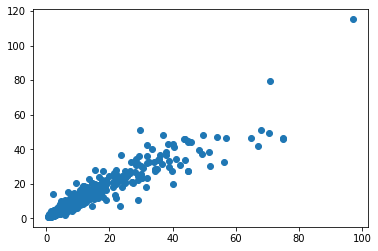

In [11]:
# novy graf - mozno este caru cez x==y
plt.scatter(y_test, predict3)
plt.set_aspect('equal')
plt.xlabel('True Values')
plt.ylabel('Predictions')

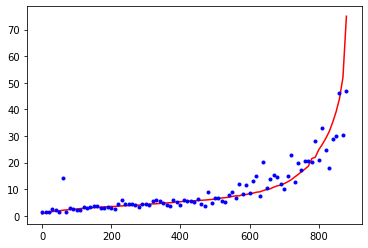

In [44]:
# Graf na zobrazenie predikcie:
#   cervena - skutocne hodnoty (zoradene)
#   modra   - predikovane hodnoty

dfl = pd.DataFrame(predict3, y_test).sort_values(by='Price')

l = list(range(0, y_test.count()))
plt.plot(l[::10], dfl.index[::10], c='red')     # y_test
plt.plot(l[::10], dfl[0][::10], '.', c='blue')  # predict

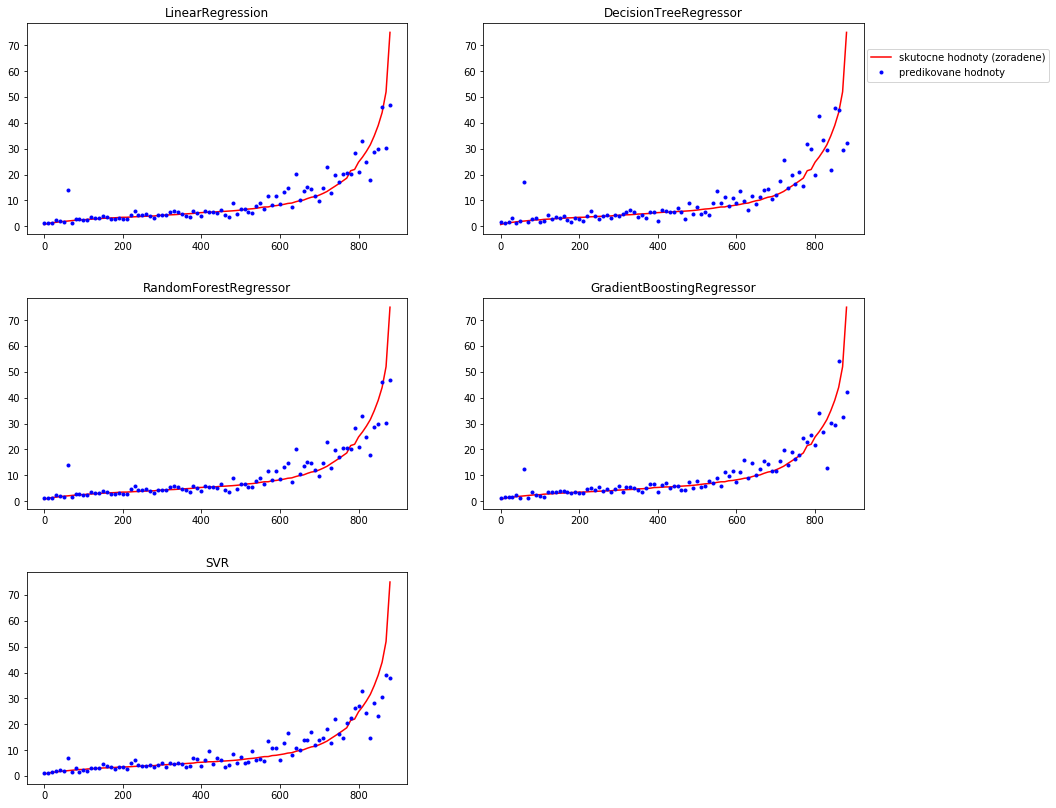

In [165]:
df1 = pd.DataFrame(predict1, y_test).sort_values(by='Price')
df2 = pd.DataFrame(predict2, y_test).sort_values(by='Price')
df3 = pd.DataFrame(predict3, y_test).sort_values(by='Price')
df4 = pd.DataFrame(predict4, y_test).sort_values(by='Price')
df5 = pd.DataFrame(predict5, y_test).sort_values(by='Price')

import matplotlib.patches as mpatches

# Setting up the plot surface
fig = plt.figure(figsize=(15, 14))
gs = GridSpec(nrows=3, ncols=2, hspace= 0.3)

# First axes
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(l[::10], dfl.index[::10], c='red')
ax0.plot(l[::10], dfl[0][::10], '.', c='blue')
ax0.set_title("LinearRegression")


# Second axes
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(l[::10], df2.index[::10], c='red',  label='skutocne hodnoty (zoradene)')
ax1.plot(l[::10], df2[0][::10], '.', c='blue', label='predikovane hodnoty')
ax1.set_title("DecisionTreeRegressor")
plt.gca().legend(loc='center right', bbox_to_anchor=(1.5, 0.8), prop={'size': 10})

# Third axes
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(l[::10], df3.index[::10], c='red')
ax2.plot(l[::10], df3[0][::10], '.', c='blue')
ax2.set_title("RandomForestRegressor")

# 4. axes
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(l[::10], df4.index[::10], c='red')
ax3.plot(l[::10], df4[0][::10], '.', c='blue')
ax3.set_title("GradientBoostingRegressor")

# 5. axes
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(l[::10], df5.index[::10], c='red')
ax4.plot(l[::10], df5[0][::10], '.', c='blue')
ax4.set_title("SVR")

#fig.savefig('gridspec.png') # save whole cell with graphs as image

### Trenovanie vybranych modelov s inou vzorkou dat

In [215]:
x_features = ['Year','Kilometers_Driven', 'Owner_Type',
              'Power', 'Engine'] # manufacturer, v traine one hot vytvoril o 3 stlpce viac co vadilo v scaling-u, co s tym?

x_train, x_test, x_valid, y_train, y_test, y_valid = data_split(x_features, df_train, df_test)
x_train, x_test, x_valid = encoding(x_train, x_test, x_valid)
x_train, x_test, x_valid = scaling(x_train, x_test, x_valid)

Data rozdelene: train = 4140, test = 882, valid = 882


In [203]:
predict1 = train_evaluate_model(LinearRegression())
predict2 = train_evaluate_model(DecisionTreeRegressor())
predict3 = train_evaluate_model(RandomForestRegressor())
predict4 = train_evaluate_model(GradientBoostingRegressor())
predict5 = train_evaluate_model(SVR())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE:  41.7414823376248
R2:  0.6752184817736443


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
RMSE:  32.021071752960445
RMSLE:  0.09592995757280985
R2:  0.7508509109704669


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimato

In [214]:
x_train


,Year,Kilometers_Driven,Power,Engine,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2011,77000,73.9,1199.0,1,0,0,0
1,2016,19947,78.9,1197.0,1,0,0,0
2,2014,70963,140.0,2179.0,1,0,0,0
3,2013,115195,74.0,1248.0,1,0,0,0
4,2011,58752,73.9,1198.0,1,0,0,0
...,...,...,...,...,...,...,...,...
4208,2015,27000,99.6,1498.0,1,0,0,0
4209,2019,9000,158.0,2198.0,1,0,0,0
4210,2013,140000,140.0,2179.0,0,0,1,0
4211,2014,76414,98.6,1498.0,1,0,0,0


In [ ]:
x_train[:10]

### Hyperparameter tuning
- vykoname na najlepsom modeli (RDF) pre maximalizovanie uspesnosti

In [13]:
# skusim postupne vacsie intervaly, potom podla vysledkov prehladat na mensich intervaloch

params = {
    'max_depth': stats.randint(1,15),
    'min_samples_leaf': stats.randint(1,5),
    'min_samples_split' : stats.randint(2,20),
    'n_estimators' : [90,100,110,120,130,140,150,160,170,180,190]
}

random_optimization = RandomizedSearchCV(RandomForestRegressor(random_state=0), param_distributions=params, 
                                           random_state=0, n_jobs=-1, n_iter = 50)

random_optimization.fit(x_valid, y_valid)


# RandomForest
model = random_optimization.best_estimator_
model.fit(x_train, y_train)

print("---GradBoosReg---")         
predict = model.predict(x_test)
print("RMSE: ", mean_squared_error(y_test, predict)) 
print("RMSLE: ", mean_squared_log_error(y_test, predict))
print("R2: ", r2_score(y_test, predict))  
print(model.get_params)
print()

concat = zip(model.feature_importances_, x_features)
for x, y in sorted(concat):
  print(x, y)


---GradBoosReg---
RMSE:  13.77893581614147
RMSLE:  0.04340603420925196
R2:  0.8927890567538339
<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=130, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)>

0.004349390572573062 Seats
0.004715613962746901 Engine
0.008640172503557477 Price_km
0.025366698410288643 Transmission
0.04727239469812211 Kilometers_Driven
0.05737523124573215 Power
0.1665533599604062 Year
0.6848037407704685 Owner_Type
